In [211]:
import pandas as pd
import numpy as np
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.utils import resample



In [190]:
df = pd.read_csv(os.path.dirname(os.getcwd())+"\\EDA\\clean_data.csv")
# df["mean_salary"] = (df['max_salary']+df['min_salary'])/2
dropped_empty_jd = df[df['Job Description']!= 'No Job Description']
ds = dropped_empty_jd.dropna()[["Job Description",'min_salary']]

In [191]:
ds

,Job Description,min_salary
0,Are you eager to roll up your sleeves and harn...,37
1,Overview\n\nProvides analytical and technical ...,37
2,We’re looking for a Senior Data Analyst who ha...,37
3,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,37
4,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,37
...,...,...
11794,OverviewPowerSchool is looking for an analyst ...,58
11795,Job Description\nAbout us:\n\nStaffigo is in t...,58
11796,• 5 yrs relevant experience in:- Experience wi...,58
11797,Job Description\n\nNew businesses are making t...,58


0    10218
1     1581
Name: min_salary, dtype: int64

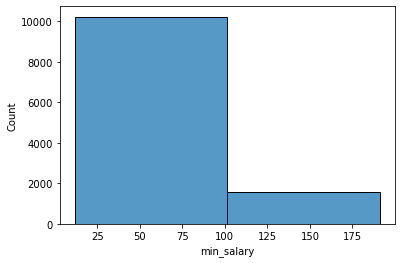

In [192]:
sns.histplot(ds["min_salary"],bins=2)
np.histogram_bin_edges(ds["min_salary"], bins=2)
ds["min_salary"] = pd.cut(ds["min_salary"],bins=[0,100,max(ds["min_salary"])],labels=False)
ds["min_salary"].value_counts()

### Plot wordclouds of the different salary categories

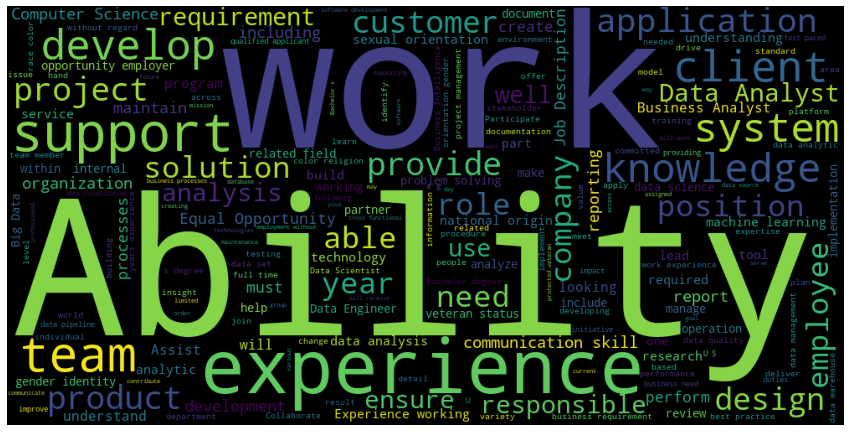

            0         1
0     Ability  1.000000
1        work  0.933804
2  experience  0.897951
3     support  0.878914
4        team  0.717337


In [226]:
import wordcloud
import matplotlib.pyplot as plt

unique_string=(" ").join(ds.loc[ds["min_salary"]==0,"Job Description"])
wordcloud_ = wordcloud.WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_)
plt.axis("off")
plt.show()

low_salary_scores = pd.DataFrame.from_dict(wordcloud_.words_.items())
print(low_salary_scores.head(5))

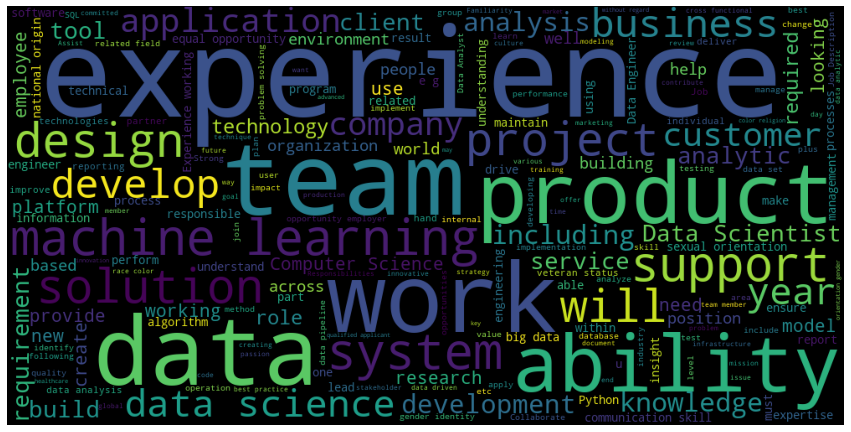

            0         1
0  experience  1.000000
1        team  0.642044
2        work  0.570559
3        data  0.546995
4     product  0.428118


In [227]:
unique_string=(" ").join(ds.loc[ds["min_salary"]==1,"Job Description"])
wordcloud_ = wordcloud.WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_)
plt.axis("off")
plt.show()

high_salary_scores = pd.DataFrame.from_dict(wordcloud_.words_.items())
print(high_salary_scores.head(5))

In [193]:
X_train, X_test, y_train, y_test = train_test_split(ds["Job Description"], ds["min_salary"], test_size=0.2, random_state=42,shuffle=True) # Train + val & test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42,shuffle=True) # Train & val

In [218]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text
# coun_vect = CountVectorizer(stop_words='english',preprocessor=preprocess_text,min_df=2,max_df=5)
# count_matrix = coun_vect.fit_transform(X_train.iloc[0:10])
# count_array = count_matrix.toarray()
# test = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names())
# print(test)

   ability  access  accuracy  act  addition  additional  advanced  agency  \
0        0       1         0    1         1           0         1       4   
1        0       0         1    0         0           0         1       0   
2        0       0         0    0         0           0         0       0   
3        0       0         0    0         0           0         0       0   
4        6       6         0    4         1           6         0       1   
5        2       0         0    0         0           0         2       0   
6        0       0         0    1         0           1         0       0   
7        2       0         0    0         0           0         0       0   
8        1       0         1    0         0           0         0       0   
9        1       0         1    0         0           0         0       0   

   algorithm  algorithms  ...  visualization  ways  wide  working  world  \
0          0           0  ...              0     1     1        3      0   


C:\Users\johma\miniconda3\envs\gen_ml_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Correct predictions:  86.69 %


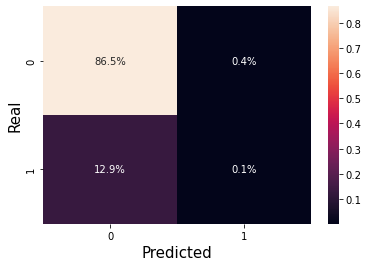

In [219]:
def plot_heatmap(y_true,y_pred):
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf/len(y_true),annot=True,fmt=".1%")
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Real', fontsize = 15)
    p = np.around(np.sum(np.diag(conf))/len(y_true)*100,2)
    print("Correct predictions: ",p,"%")


text_clf_NB = Pipeline([
    ('vect', CountVectorizer(stop_words='english',preprocessor=preprocess_text,min_df=2,max_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf_NB.fit(X_train, y_train)

y_pred = text_clf_NB.predict(X_val)



plot_heatmap(y_val,y_pred)

Correct predictions:  86.94 %


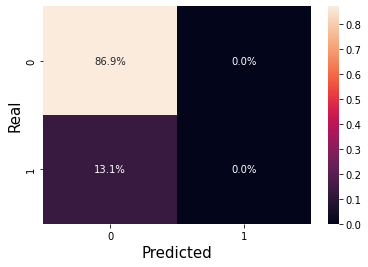

In [201]:
text_clf_SVM = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf_SVM.fit(X_train, y_train)

y_pred = text_clf_SVM.predict(X_val)

plot_heatmap(y_val,y_pred)

### Lets upsample the minority category (high minimum salary)

In [202]:

X_train_minority = X_train[y_train == 1]
y_train_minority = y_train[y_train == 1]
#set other classes to another dataframe
X_train_majority = X_train[y_train != 1]
y_train_majority = y_train[y_train != 1]
#upsample the minority class
# n_sample = int((sum((y_train == 0)*1)+sum((y_train == 1)*1))/2)
n_sample = int((sum((y_train == 0)*1)))

X_train_minority_upsampled = resample(X_train_minority,random_state=42,n_samples=n_sample,replace=True)
y_train_minority_upsampled = resample(y_train_minority,random_state=42,n_samples=n_sample,replace=True)
#concatenate the upsampled dataframe
X_upsampled = pd.concat([X_train_minority_upsampled,X_train_majority])
y_upsampled = pd.concat([y_train_minority_upsampled,y_train_majority])


Correct predictions:  72.21 %


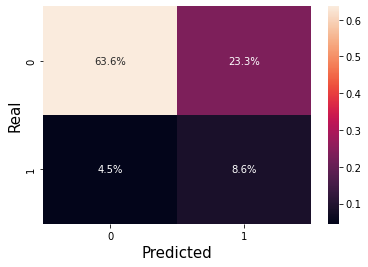

In [203]:
text_clf_NB.fit(X_upsampled, y_upsampled)
y_pred = text_clf_NB.predict(X_val)
plot_heatmap(y_val,y_pred)

Correct predictions:  74.15 %


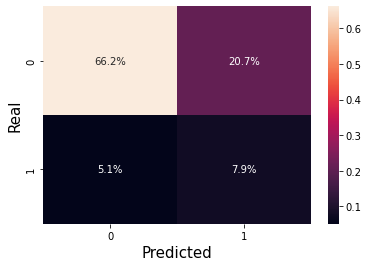

In [204]:
text_clf_SVM.fit(X_upsampled, y_upsampled)
y_pred = text_clf_SVM.predict(X_val)
plot_heatmap(y_val,y_pred)